# Livrable 2 - Traitement d'images

Groupe 2 :
- Brenda DJIGUEMDE
- Bruno DIAS
- Dany KHADHAR
- Romaric DEMBELE

## Contexte

L'objectif est de manipuler un ensemble d'images pour les optimiser pour le traitement par des algorithmes d'apprentissage automatique. Le processus à mettre en œuvre est une opération de débruitage. Ce notebook Jupyter détaille ces étapes de prétraitement et évalue leur efficacité. Ces algorithmes utilisent des auto-encodeurs à convolution pour améliorer la qualité de l'image.
Cahier de charges de ce livrable :

- Le code de chargement du fichier.
- Le code du débruitage sur un sous-ensemble d'images bruitées. Le code doit être accompagné d'explications.
- Une étude de cas.

## 1. Préparation de l'environnement 

### 1.1 Imports de librairies

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import numpy as np

### 1.2 Variables globales

On définit des paramètres pour l'entraînement de notre modèle de machine learning. `BATCH_SIZE` est la taille du lot d'échantillons qui sera passé à travers le réseau à chaque itération d'entraînement. `DATASET_PATH` est le chemin vers le répertoire contenant l'ensemble de données. `EPOCHS` est le nombre total de passages à travers l'ensemble de données d'entraînement. `STEPS_PER_EPOCH` et `VALIDATION_STEPS` sont respectivement le nombre de lots d'échantillons d'entraînement et de validation que le modèle verra à chaque époque, calculés en divisant le nombre total d'échantillons par la taille du lot.

In [4]:
BATCH_SIZE = 16  # Taille du batch
DATASET_PATH = './dataset_livrable_2' 

# Configuration de paramètres pour l'entraînement
EPOCHS = 200 # Nombre d'époques pour l'entraînement
STEPS_PER_EPOCH  = 120 // BATCH_SIZE  # Nombre de batches d'entraînement par époque
VALIDATION_STEPS = 32 // BATCH_SIZE  # Nombre de batches de validation par époque
IMG_SIZE = 224

## 2. Les données

### 2.1 Chargement des données

Dans ce code, nous commençons par créer un `DataFrame` qui contient les chemins vers toutes les images dans le répertoire spécifié. Ensuite, nous configurons un `ImageDataGenerator`pour normaliser les images et appliquer des modifications aléatoires comme la rotation, le zoom, et le décalage horizontal et vertical. Nous divisons également les données en un ensemble d'entraînement et un ensemble de validation avec une répartition de 80/20. Ensuite, nous utilisons `flow_from_dataframe` pour créer des générateurs de données d'entraînement et de validation qui chargent les images, les transforment en fonction des paramètres de l'`ImageDataGenerator`, et les regroupent en lots. Enfin, nous affichons la forme du premier lot de données d'entraînement pour vérifier que tout fonctionne comme prévu.

`ImageDataGenerator` est une classe de Keras qui est utilisée pour générer des lots d'images avec des transformations en temps réel. Cela signifie qu'elle peut générer des images modifiées à la volée pendant l'entraînement, ce qui permet de charger des images "à l'infini". On l'utilise dans notre cas car nous avons que 150 images. Cela permet d'ajouter de la variété en générant des images modifiées.

In [5]:
# Création d'un DataFrame contenant les chemins des images
image_paths = [os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_df = pd.DataFrame({'filename': image_paths})

# Configuration de l'ImageDataGenerator pour la normalisation en modifiant de façon aléatoire la rotation, le zoom, le décalage horizontal et vertical
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,
    width_shift_range=1,
    height_shift_range=1,
    zoom_range=2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Définit la répartition d'entraînement et de validation

)
# Création du générateur de données d'entraînement et de validation 
train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    x_col='filename',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode=None,  # Pas de labels car l'image est sa propre cible
    batch_size=BATCH_SIZE,
    subset='training',  # Défini pour utiliser la répartition de validation
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    x_col='filename',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode=None,  # Pas de labels
    batch_size=BATCH_SIZE,
    subset='validation',  # Défini pour utiliser la répartition de validation
    shuffle=True
)

# Affichage des informations sur le générateur
for data_batch in train_generator:
    print('Batch shape:', data_batch.shape)
    break  # Affiche seulement le premier lot


Found 119 validated image filenames.
Found 29 validated image filenames.
Batch shape: (16, 224, 224, 3)


### 2.2 Affichage des images

On affiche ensuite 9 images. 

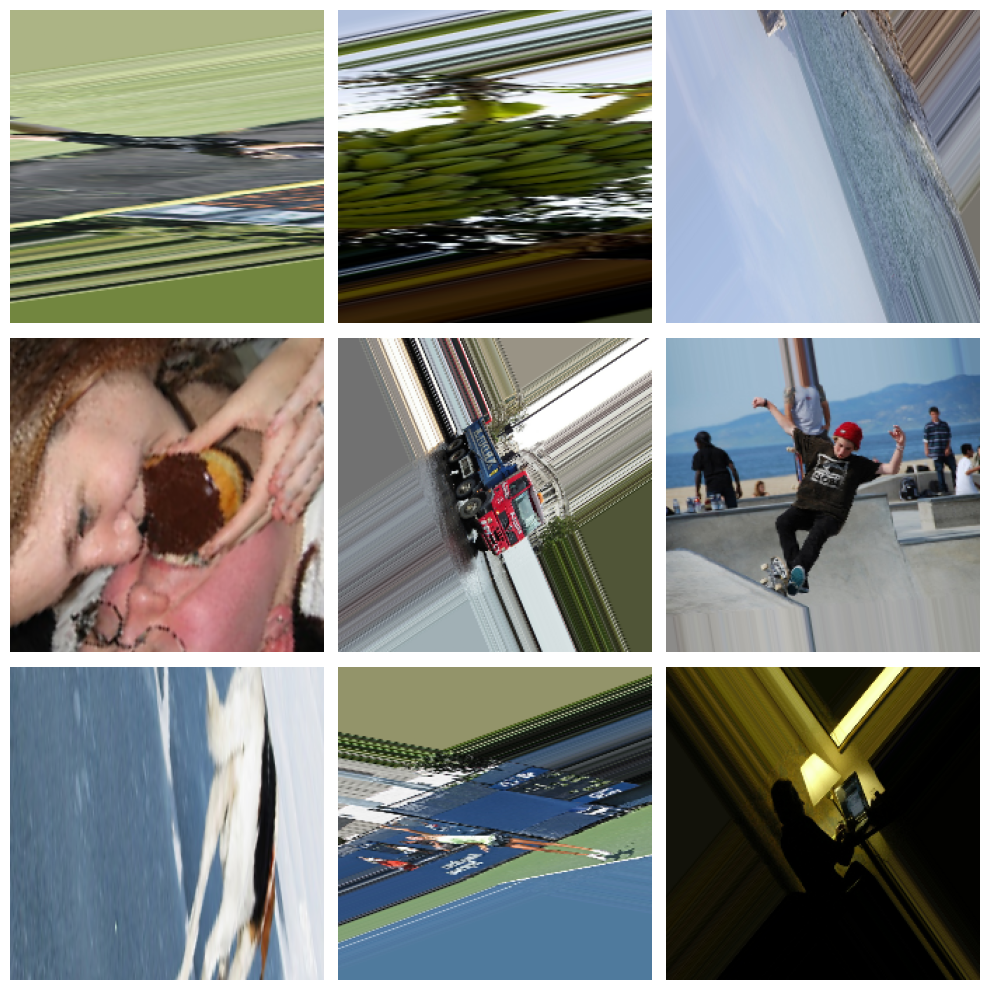

In [6]:
import matplotlib.pyplot as plt

def show_images(train_generator):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Crée un grid de 3x3 pour les images
    axes = axes.flatten()
    batch = next(iter(train_generator))  # Récupère un lot d'images du générateur
    for i, ax in enumerate(axes):
        if i < len(batch):  # Vérifie si l'index est inférieur au nombre d'images dans le lot
            ax.imshow(batch[i])  # Affiche l'image dans le subplot
            ax.axis('off')  # Désactive les axes
    plt.tight_layout()  # Ajuste la disposition
    plt.show()

# Appelle la fonction pour montrer les images
show_images(train_generator)


### 2.3 Création d'un jeu de données bruité

Dans ce code, nous avons défini deux fonctions principales pour ajouter du bruit à nos images. Nous avons choisi d'ajouter trois types de bruit : gaussien, sel et poivre, et poisson, de manière aléatoire. Le bruit gaussien est ajouté en générant des valeurs aléatoires à partir d'une distribution normale. Le bruit de sel et de poivre ajoute du "sel" (pixels blancs) et du "poivre" (pixels noirs) à l'image. Le bruit de Poisson est généré à partir d'une distribution de Poisson. L'ajout de ces types de bruit à nos images nous permet de rendre notre modèle plus robuste. En effet, dans le monde réel, les images que notre modèle pourrait avoir à traiter seront probablement affectées par divers types de bruit. En entraînant notre modèle sur des images bruitées, nous espérons qu'il sera capable de bien fonctionner même lorsque les images d'entrée ne sont pas parfaites.

In [8]:
import numpy as np

def add_noise(img, noise_level=0.1):
    # Choisis un type de bruit aléatoirement
    noise_types = ['gaussian', 'salt_pepper', 'poisson']
    noise_type = np.random.choice(noise_types)

    if noise_type == 'gaussian':
        noise = np.random.normal(loc=0.0, scale=noise_level, size=img.shape)
        img_noisy = img + noise
    elif noise_type == 'salt_pepper':
        row, col, ch = img.shape
        s_vs_p = 0.5
        amount = noise_level
        out = np.copy(img)
        # Salt mode
        num_salt = np.ceil(amount * img.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                  for i in img.shape]
        out[coords[0], coords[1], :] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * img.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in img.shape]
        out[coords[0], coords[1], :] = 0
        img_noisy = out
    elif noise_type == 'poisson':
        vals = len(np.unique(img))
        vals = 2 ** np.ceil(np.log2(vals))
        img_noisy = np.random.poisson(img * vals) / float(vals)
    else:
        raise ValueError("Unsupported noise type!")

    img_noisy = np.clip(img_noisy, 0, 1)  # Garantie que les valeurs restent dans [0, 1]
    return img_noisy

def noisy_generator(generator, noise_level=0.1):
    '''Generates pairs of noisy and original images.'''
    for batch in generator:
        original_batch = batch.copy()  # Copie les images originales avant d'ajouter les bruits 
        noisy_batch = np.array([add_noise(image, noise_level) for image in original_batch])
        yield noisy_batch, original_batch  # Retourne les images originales et les images bruitées 



On ajoute ensuite du bruit à nos différents jeux de données avec un niveau de bruitage (noise level) à 0.1. Plusieurs niveaux ont été testés mais n'ont pas eu d'impact sur la performance du modèle jusqu'à un niveau de 0.5 où il se dégrade.

In [9]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: noisy_generator(train_generator, noise_level=0.1),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),  # images bruitées
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32)   # images Originales 
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: noisy_generator(validation_generator, noise_level=0.1),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),  # images bruitées 
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32)   # images Originales 
    )
)

# Exemple d'usage
for x, y in train_dataset.take(1):
    print('Batch shape:', x.numpy().shape)

2024-04-25 08:41:39.509238: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 08:41:39.523704: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 08:41:39.523781: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 08:41:39.526219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 08:41:39.526302: I external/local_xla/xla/stream_executor

Batch shape: (16, 224, 224, 3)


Affichons quelques images originales avec leurs versions bruitées afin de vérifier que le bruitage a bien été effectué.

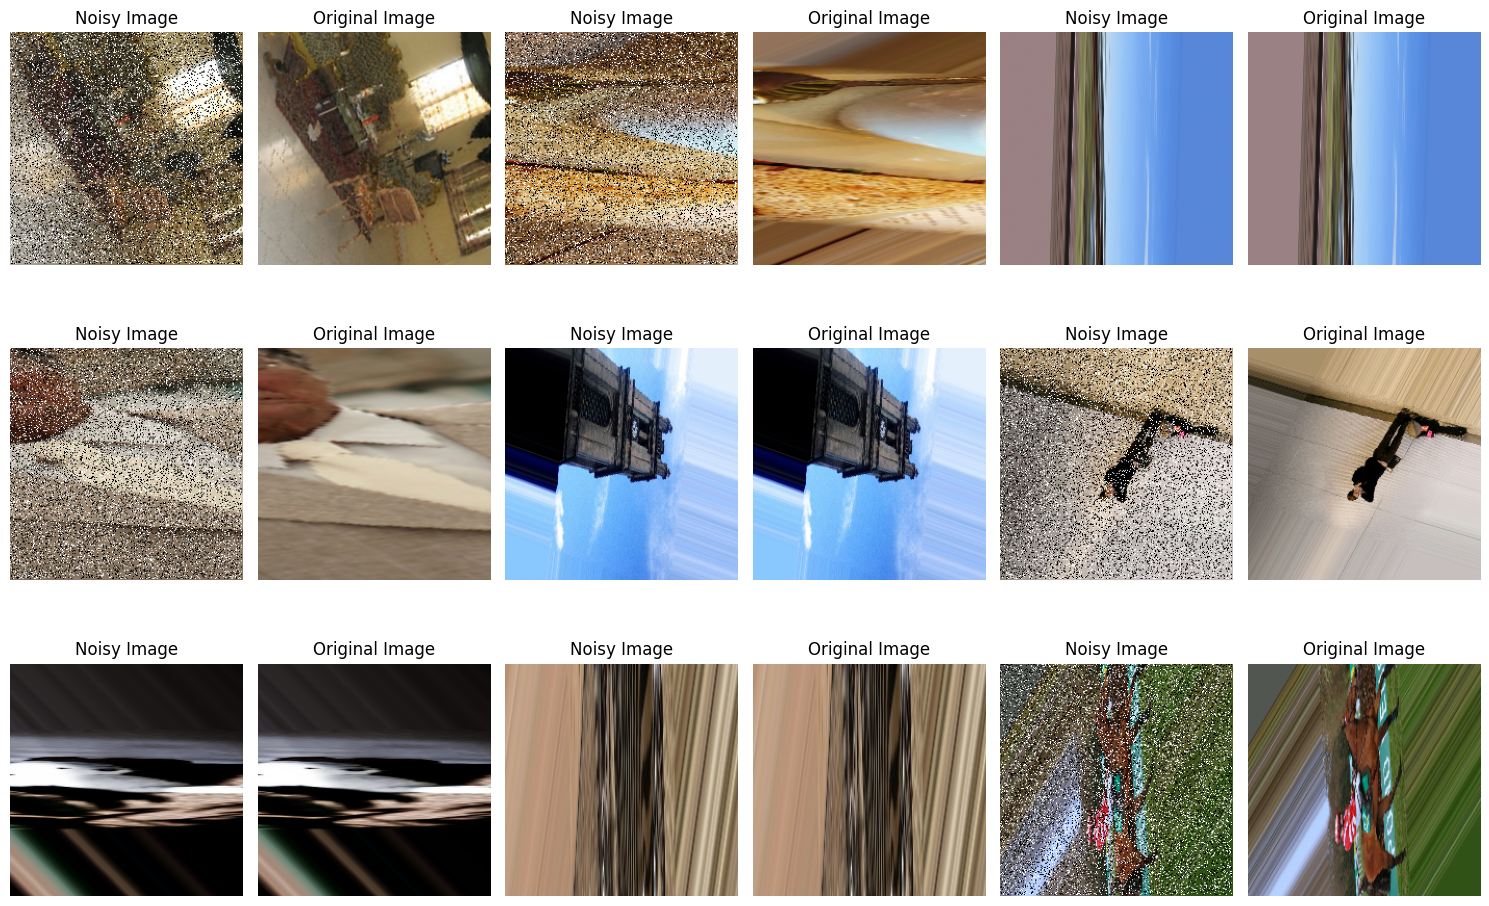

In [10]:
import matplotlib.pyplot as plt

def show_data_set_images(train_dataset):
    # Génère un batch à partir du dataset
    try:
        noisy_batch, original_batch = next(iter(train_dataset))
    except StopIteration:
        print("No more data available in the dataset.")
        return

    # Determine combien de paires d'images on peut afficher 
    num_images = len(noisy_batch)  # Récupère le nombre d'images dans le batch
    num_pairs_to_show = min(num_images, 9)  # affiche 9 paires

    # Crée une grille de 3x6 pour afficher les images
    fig, axes = plt.subplots(3, 6, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(num_pairs_to_show):
        # Affiche les images bruitées à gauche 
        ax_noisy = axes[2 * i]
        ax_noisy.imshow(noisy_batch[i])
        ax_noisy.axis('off')
        ax_noisy.set_title('Noisy Image')

        # Affiche les images originales à droite
        ax_original = axes[2 * i + 1]
        ax_original.imshow(original_batch[i])
        ax_original.axis('off')
        ax_original.set_title('Original Image')

    # Cache les axes pour les images restantes
    for j in range(2 * num_pairs_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Affichage des images bruitées
show_data_set_images(train_dataset)


## Modèle auto-encodeur

### 3.1 Création du modèle auto-encodeur

Dans notre travail, nous avons élaboré un auto-encodeur, une forme de réseau de neurones, avec l'objectif précis de débruiter nos images. L'encodeur comprime l'image bruitée en une représentation de dimension réduite, tandis que le décodeur tente de reconstruire l'image originale à partir de cette représentation, réalisant ainsi le débruitage. Les fonctions d'activation ReLU introduisent des non-linéarités, permettant au modèle d'apprendre des représentations plus complexes. Les couches MaxPooling dans l'encodeur diminuent la dimensionnalité, tandis que les couches UpSampling dans le décodeur l'augmentent, aidant à restaurer l'image originale. Nous utilisons l'optimiseur Adam, un algorithme d'optimisation qui ajuste le taux d'apprentissage pour chaque poids dans le réseau, pour minimiser la fonction de perte Mean Squared Error (MSE). La MSE mesure la moyenne des carrés des erreurs entre les images débruitées produites par notre auto-encodeur et les images originales, qui servent de labels dans notre cas. Enfin, nous avons affiné les paramètres du modèle, tels que le nombre de filtres dans les couches Conv2D et la taille du noyau, par le biais du tuning pour optimiser la capacité de débruitage du modèle.

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def build_autoencoder(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    input_img = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(96, (5, 5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(96, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(96, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(160, (3, 3), activation='relu', padding='same')(x)  # Ensure padding is 'same'
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Crée le modèle
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005355035267411966),
        loss='mse',
        metrics=['accuracy']
    )
    return autoencoder

# Build and summarize le model
autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 224, 224, 96)   │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 96)   │       230,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 56, 56, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 96)     │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 112, 112, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 160)  │       138,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 224, 224, 160)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 224, 224, 3)    │         4,323 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,963 (2.61 MB)

 Trainable params: 684,963 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Entrainement du modèle

Entraînons notre auto-encodeur sur l'ensemble de données d'entraînement. Nous spécifions un certain nombre d'époques, qui représentent le nombre de fois où l'ensemble du jeu de données est passé à travers le réseau. Nous définissons également le nombre de pas par époque, qui est le nombre de lots d'échantillons à tirer de l'ensemble de données d'entraînement à chaque époque. De plus, nous fournissons un ensemble de données de validation et le nombre de pas de validation. Ces derniers sont utilisés pour évaluer les performances du modèle sur des données non vues à chaque fin d'époque, ce qui nous permet de surveiller si le modèle surajuste les données d'entraînement. L'objet history retourné par la méthode fit contient les valeurs de perte et de métrique à chaque époque, à la fois pour l'entraînement et la validation, ce qui nous permet d'analyser la progression de l'entraînement.

In [19]:
# Entraînement de l'autoencodeur
history = autoencoder.fit(
    x=train_dataset,  # Données d'entraînement
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,  # Données de validation
    validation_steps=VALIDATION_STEPS
)

Epoch 1/200


2024-04-19 14:16:06.152356: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,96,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,96,112,112]{3,2,1,0}, f32[96,96,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-04-19 14:16:06.519399: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.367274315s
Trying algorithm eng0{} for conv (f32[16,96,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,96,112,112]{3,2,1,0}, f32[96,96,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_

6/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4054 - loss: 0.0810   

I0000 00:00:1713536179.091828      59 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 36 bytes spill stores, 36 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4100 - loss: 0.0804 - val_accuracy: 0.2671 - val_loss: 0.0495
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.3992 - loss: 0.0610 - val_accuracy: 0.5186 - val_loss: 0.0630
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.5045 - loss: 0.0557 - val_accuracy: 0.5277 - val_loss: 0.0582
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.4136 - loss: 0.0512 - val_accuracy: 0.5094 - val_loss: 0.0411
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.5446 - loss: 0.0387 - val_accuracy: 0.4255 - val_loss: 0.0416
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.4918 - loss: 0.0342 - val_accuracy: 0.4839 - val_loss: 0.0263
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.4633 - loss: 0.0234 - val_accuracy: 0.5086 - val_loss: 0.0278
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.5041 - loss: 0.0204 - val_accuracy: 0.5336 - val_loss: 0.017

### 3.3 Les métriques

On trace les courbes afin de voir l'évolution de l'`accuracy` et de la `fonction` loss suivant les époques.

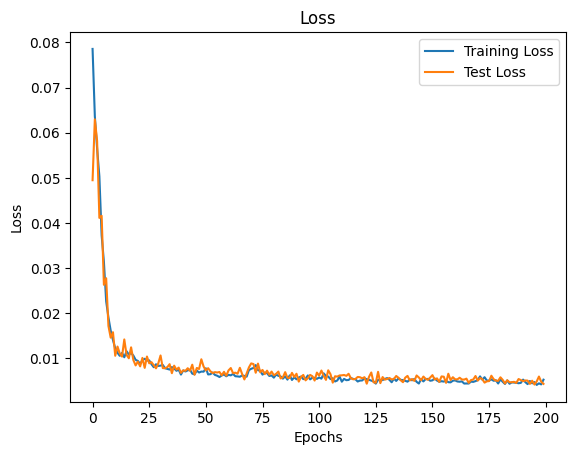

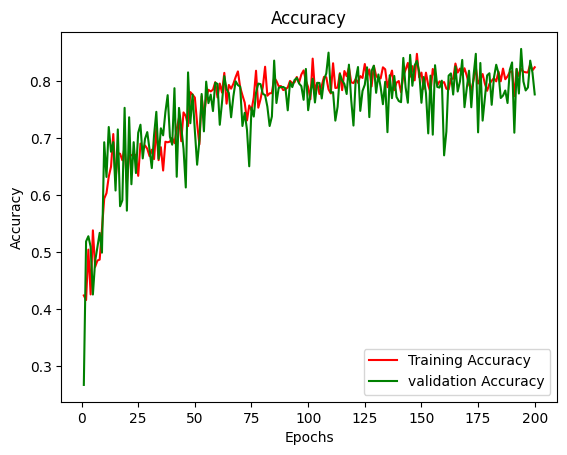

In [20]:
import matplotlib.pyplot as plt

# affichage de la courbe de loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# affichage de la courbe de l'accuracy
loss = history.history['loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



#### Analyse du graphe de perte ("Loss"):

Training Loss : Diminue rapidement au début, ce qui indique que le modèle apprend efficacement à partir des données d'entraînement. Ensuite, il semble se stabiliser, montrant peu de variations, ce qui est bon signe que le modèle converge bien.

Test Loss : Diminue également de façon similaire au training loss au début, mais avec des pics occasionnels. Ces pics pourraient indiquer des moments où le modèle a mal performé sur certaines données du test batch, mais globalement, le test loss suit de près le training loss, ce qui suggère que le modèle généralise bien et n'est pas en surapprentissage.


#### Analyse du graphe de précision ("Accuracy"):

Training Accuracy : Augmente rapidement puis fluctue autour de 0.8 sans montrer d'amélioration significative. Cela signifie que le modèle a atteint sa capacité d'apprentissage maximale avec l'architecture et les données actuelles.

Validation Accuracy : Suit de près la training accuracy, ce qui est positif car cela signifie que le modèle ne souffre pas de surapprentissage. Cependant, les fluctuations suggèrent que le modèle pourrait être sensible à certains échantillons de validation ou que la validation set pourrait contenir des données bruitées ou plus difficiles à généraliser.

### 3.4 Les prédictions

On affiche les images débruitées grâce à notre auto-encodeur. Ces images proviennent du premier batch de notre jeu de données de validation.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


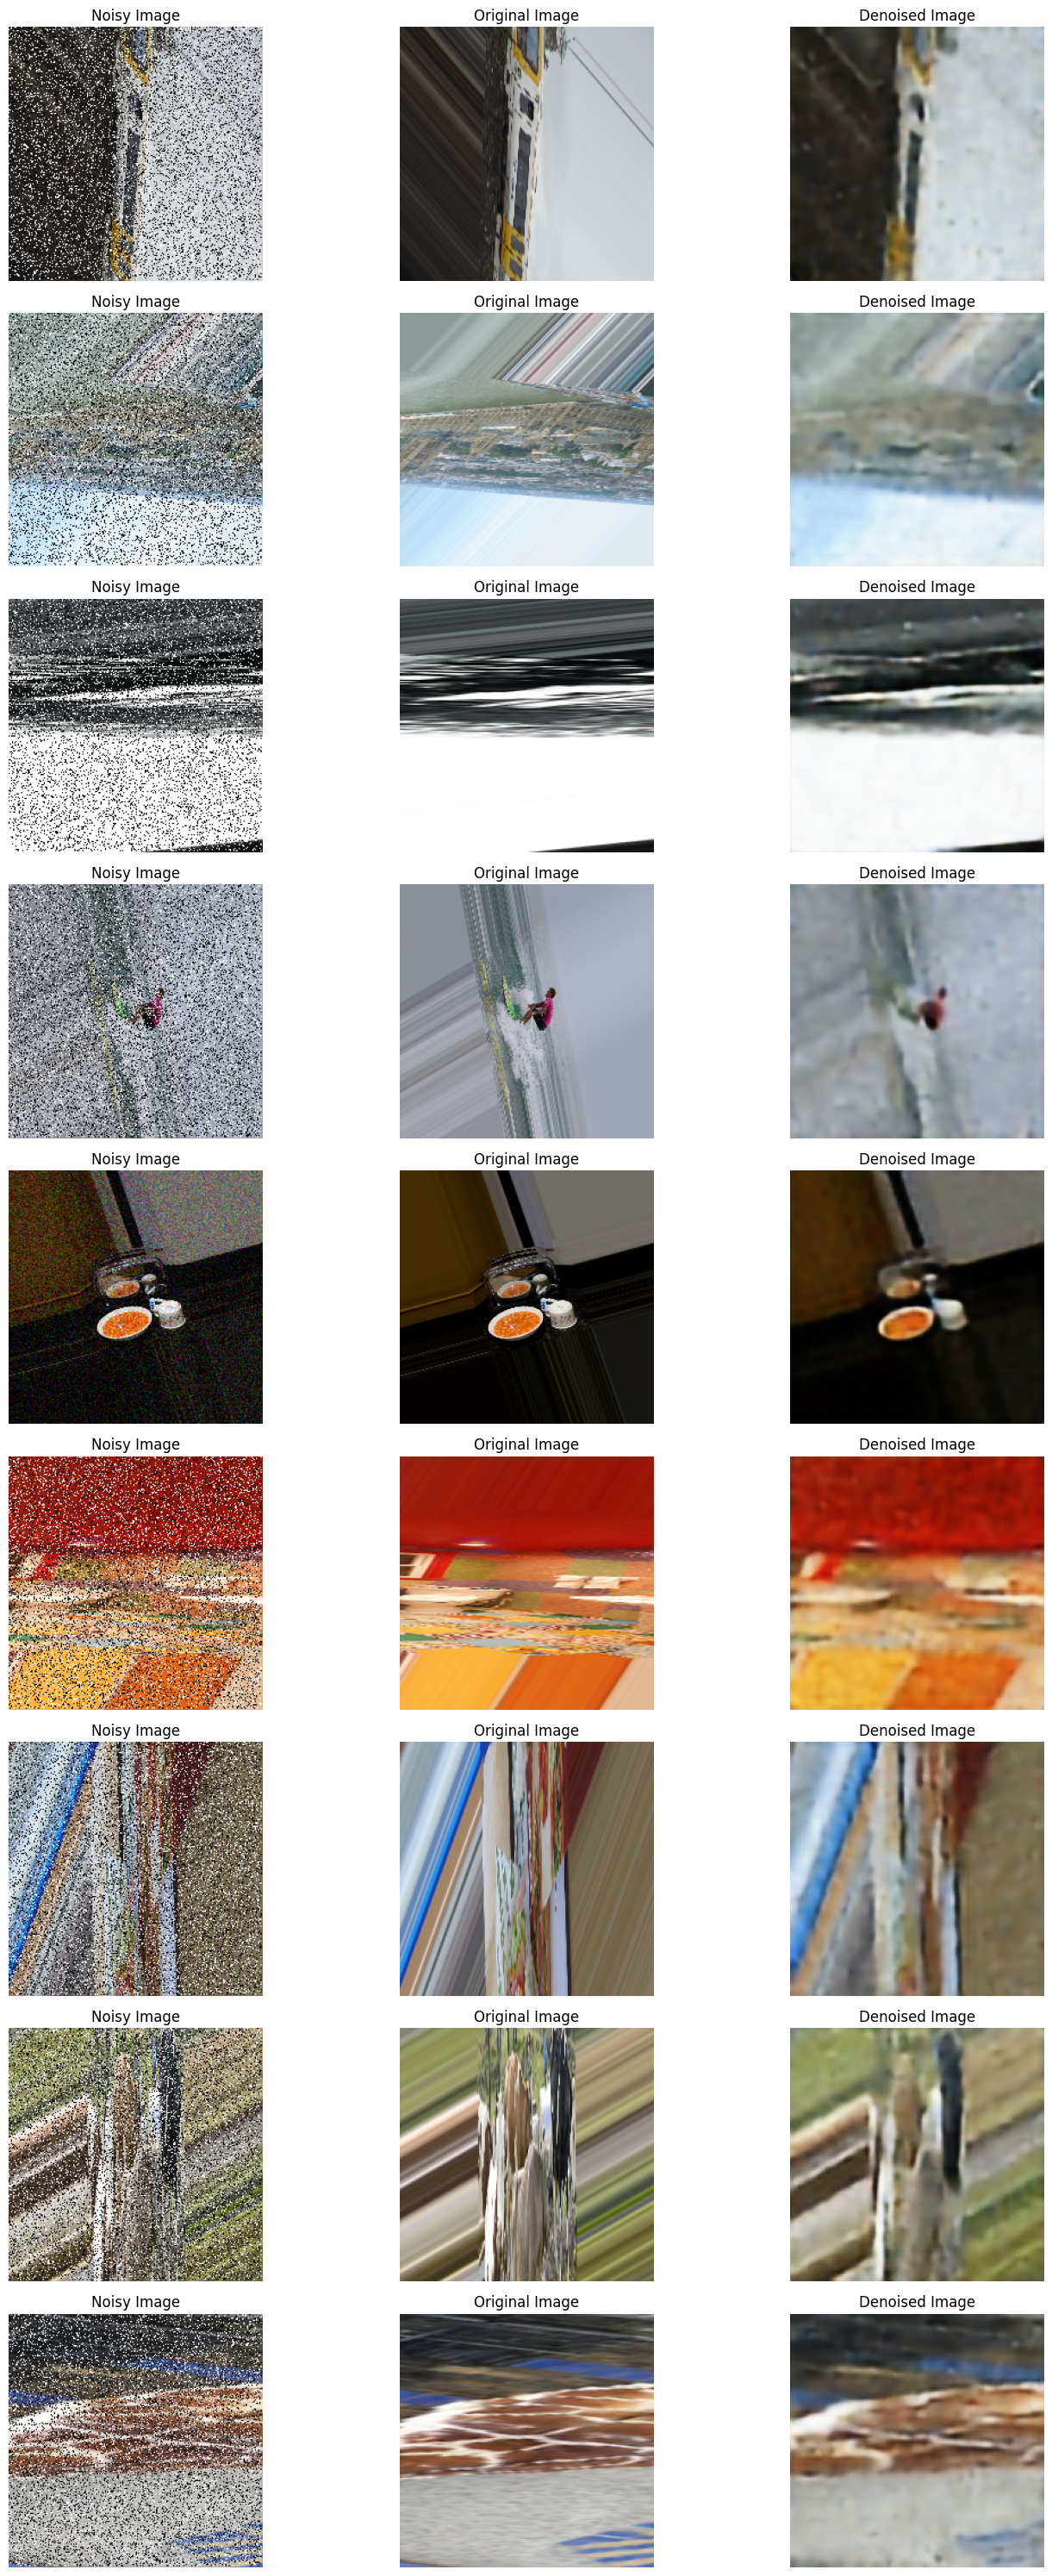

In [21]:

def show_predictions(autoencoder, dataset):
    # Génère un batch à partir du dataset
    try:
        noisy_batch, original_batch = next(iter(dataset))
    except StopIteration:
        print("No more data available in the dataset.")
        return

    # génère les images débruitées
    denoised_batch = autoencoder.predict(noisy_batch)

    # Détermine combien de paires d'images on peut afficher
    num_images = len(noisy_batch)  # Récupère le nombre d'images dans le batch
    num_pairs_to_show = min(num_images, 9)  # Affiche 9 paires

    #  Crée une grille de 3x6 pour afficher les images
    fig, axes = plt.subplots(9, 3, figsize=(15, 30))
    axes = axes.flatten()

    for i in range(num_pairs_to_show):
        # affiche l'image bruitée à gauche
        ax_noisy = axes[3 * i]
        ax_noisy.imshow(noisy_batch[i])
        ax_noisy.axis('off')
        ax_noisy.set_title('Noisy Image')

        # affiche l'image originale au milieu
        ax_original = axes[3 * i + 1]
        ax_original.imshow(original_batch[i])
        ax_original.axis('off')
        ax_original.set_title('Original Image')

        # affiche l'image débruitée à droite
        ax_denoised = axes[3 * i + 2]
        ax_denoised.imshow(denoised_batch[i])
        ax_denoised.axis('off')
        ax_denoised.set_title('Denoised Image')

    # Cache les axes pour les images restantes
    for j in range(3 * num_pairs_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()



# Affiche les prédictions
show_predictions(autoencoder, validation_dataset)

On voit que les images sont débruitées mais restent cependant un peu floues.

### 3.5 Evaluation de la qualité des images débruitées.

Dans ce segment de code, nous définissons d'abord une fonction `predict_and_calculate_psnr` qui utilise notre modèle pour débruiter des images et calculer le rapport signal sur bruit en `pic (PSNR)` entre les images originales et les images débruitées. Ensuite, nous définissons une fonction `evaluate_model` pour évaluer notre auto-encodeur sur un ensemble de données. Cette fonction itère sur l'ensemble de données par lots, en s'arrêtant après un nombre spécifié de lots. Pour chaque lot, elle calcule le `PSNR` et l'ajoute à une liste. Elle enregistre également le temps nécessaire pour traiter chaque lot et le nombre total de lots traités. Après avoir traité tous les lots, elle concatène toutes les valeurs de `PSNR` et calcule la moyenne. Enfin, elle affiche le temps total d'évaluation et le `PSNR` moyen. Nous utilisons cette fonction pour évaluer notre auto-encodeur sur l'ensemble de données de validation, en supposant que nous avons défini un nombre approprié de pas de validation.

Le `PSNR` est une mesure couramment utilisée pour évaluer la qualité de la reconstruction d'images. Un PSNR plus élevé indique une meilleure qualité de reconstruction. 

In [22]:
import tensorflow as tf
import time

@tf.function
def predict_and_calculate_psnr(model, noisy_images, original_images):
    denoised_images = model(noisy_images, training=False)  # Ensure inference mode
    psnr_values = tf.image.psnr(original_images, denoised_images, max_val=1.0)
    return psnr_values

def evaluate_model(autoencoder, dataset, num_batches):
    psnr_values = []
    batch_count = 0
    start_time = time.time()

    # Itère sur le dataset avec une limite sur le nombre de batches
    for noisy_batch, original_batch in dataset:
        if batch_count >= num_batches:
            break  # Arrête la boucle après le nombre spécifié de batches

        batch_start_time = time.time()

        # Effectue la prédiction et calcule le PSNR
        psnr = predict_and_calculate_psnr(autoencoder, noisy_batch, original_batch)

        # Ajoute les valeurs de PSNR à la liste, en gardant les opérations dans TensorFlow
        psnr_values.append(psnr)  # Ajoute le tensor TF à la liste

        batch_end_time = time.time()
        batch_count += 1

        # Logs pour chaque batch
        print(f"Batch {batch_count}: Calculated PSNR for {len(noisy_batch)} images.")
        print(f"Time for batch {batch_count}: {batch_end_time - batch_start_time:.2f} seconds")

    total_time = time.time() - start_time

    # Concatène toutes les valeurs de PSNR et calcule la moyenne
    all_psnr = tf.concat(psnr_values, axis=0)
    average_psnr = tf.reduce_mean(all_psnr).numpy()  # Converti en numpy après les calculs

    # Logs de processus final
    print(f"Evaluated {batch_count} batches in total.")
    print(f"Total evaluation time: {total_time:.2f} seconds")
    print(f"Average PSNR: {average_psnr:.2f} dB")

    return average_psnr

# Évalue le modèle sur le dataset de validation
psnr = evaluate_model(autoencoder, validation_dataset, VALIDATION_STEPS)
print(f'Average PSNR: {psnr:.2f} dB')


Batch 1: Calculated PSNR for 16 images.
Time for batch 1: 0.53 seconds
Batch 2: Calculated PSNR for 13 images.
Time for batch 2: 0.30 seconds
Evaluated 2 batches in total.
Total evaluation time: 1.29 seconds
Average PSNR: 23.81 dB
Average PSNR: 23.81 dB


Notre `PSNR moyen est de 23.81 dB`, ce qui est relativement faible. Cela veut dire que notre auto-encodeur n'est pas capable de débruiter efficacement les images. Une raison possible de ce faible score pourrait être le nombre insuffisant d'images dans notre ensemble de données. En effet, un ensemble de données plus grand aurait permis à notre modèle d'apprendre une plus grande variété de caractéristiques de bruit, ce qui aurait pu améliorer sa capacité à débruiter les images. Par conséquent, pour améliorer les performances de notre auto-encodeur, nous pourrions envisager d'augmenter la taille de notre ensemble de données.

## 4. Le tuning 

Nous définissons une classe `AutoencoderHyperModel` qui construit un auto-encodeur avec des hyperparamètres tels que le nombre de filtres et la taille du noyau pour chaque couche convolutive, et le taux d'apprentissage pour l'optimiseur Adam. Nous utilisons ensuite le tuner Hyperband de Keras Tuner pour optimiser ces hyperparamètres, en cherchant les meilleurs sur l'ensemble de données d'entraînement et en validant sur l'ensemble de données de validation. Après la recherche, nous récupérons et imprimons les meilleurs hyperparamètres, puis nous construisons un nouveau modèle avec ces hyperparamètres et affichons son résumé.

In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, Hyperband

class AutoencoderHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
        
    def build(self, hp):
        input_img = Input(shape=self.input_shape)
        # Encoder
        x = Conv2D(
            filters=hp.Int('encoder_filter_1', min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice('encoder_kernel_size_1', values=[3, 5]),
            activation='relu',
            padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(
            filters=hp.Int('encoder_filter_2', min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice('encoder_kernel_size_2', values=[3, 5]),
            activation='relu',
            padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        # Decoder
        x = Conv2D(
            filters=hp.Int('decoder_filter_1', min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice('decoder_kernel_size_1', values=[3, 5]),
            activation='relu',
            padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(
            filters=hp.Int('decoder_filter_2', min_value=32, max_value=160, step=32),
            kernel_size=hp.Choice('decoder_kernel_size_2', values=[3, 5]),
            activation='relu',
            padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer=Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='mse', metrics=["accuracy"])

        return autoencoder

input_shape = (IMG_SIZE, IMG_SIZE, 3)
hypermodel = AutoencoderHyperModel(input_shape)

tuner = Hyperband(
    hypermodel,
    objective='val_loss',
    max_epochs=200,
    factor=3,
    directory='autoencoder_tuning',
    project_name='autoencoder_denoise',
    seed=42
)

# Recherche des hyperparamètres
tuner.search(train_dataset, validation_data=validation_dataset, epochs=200, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS)

# Récupère les meilleurs hyperparamètres
best_hps = tuner.get_best_hyperparameters()[0]
# Affiche les meilleurs hyperparamètres
print("Best encoder hyperparameters:")
print(f"Encoder filter 1: {best_hps.get('encoder_filter_1')}")
print(f"Encoder kernel size 1: {best_hps.get('encoder_kernel_size_1')}")
print(f"Encoder filter 2: {best_hps.get('encoder_filter_2')}")
print(f"Encoder kernel size 2: {best_hps.get('encoder_kernel_size_2')}")
print("Best decoder hyperparameters:")
print(f"Decoder filter 1: {best_hps.get('decoder_filter_1')}")
print(f"Decoder kernel size 1: {best_hps.get('decoder_kernel_size_1')}")
print(f"Decoder filter 2: {best_hps.get('decoder_filter_2')}")
print(f"Decoder kernel size 2: {best_hps.get('decoder_kernel_size_2')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

# Construit le modèle avec les meilleurs hyperparamètres
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Trial 254 Complete [00h 05m 22s]
val_loss: 0.003805195912718773

Best val_loss So Far: 0.002070127986371517
Total elapsed time: 03h 50m 19s
Best encoder hyperparameters:
Encoder filter 1: 64
Encoder kernel size 1: 3
Encoder filter 2: 160
Encoder kernel size 2: 3
Best decoder hyperparameters:
Decoder filter 1: 128
Decoder kernel size 1: 3
Decoder filter 2: 160
Decoder kernel size 2: 3
Learning rate: 0.001772507252479043


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 160)  │        92,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 128)    │       184,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 160)  │       184,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 224, 224, 160)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 3)    │         4,323 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,363 (1.78 MB)

 Trainable params: 467,363 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Testons avec les meilleurs hyperparamètres trouvés par le tunner.

Epoch 1/200
1/7 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.2877 - loss: 0.0759

I0000 00:00:1713535542.887301      61 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 36 bytes spill stores, 36 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 905ms/step - accuracy: 0.3353 - loss: 0.0801 - val_accuracy: 0.3404 - val_loss: 0.0469
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.3466 - loss: 0.0536 - val_accuracy: 0.2952 - val_loss: 0.0450
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.3501 - loss: 0.0424 - val_accuracy: 0.4094 - val_loss: 0.0290
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.4384 - loss: 0.0294 - val_accuracy: 0.5660 - val_loss: 0.0255
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.5123 - loss: 0.0245 - val_accuracy: 0.5678 - val_loss: 0.0213
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.4972 - loss: 0.0170 - val_accuracy: 0.5977 - val_loss: 0.0139
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.5678 - loss: 0.0144 - val_accuracy: 0.5991 - val_loss: 0.0115
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.6381 - loss: 0.0116 - val_accuracy: 0.6380 - val_loss: 0.0

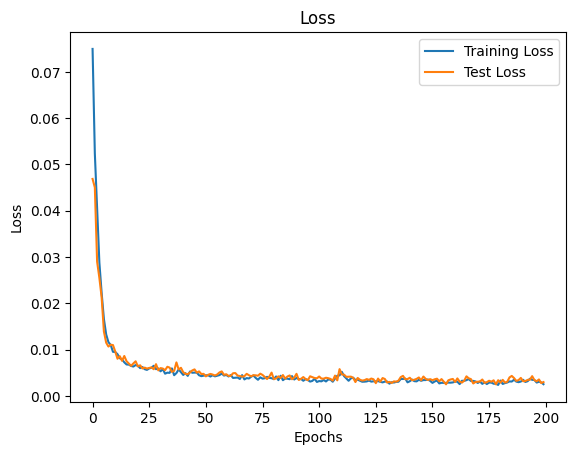

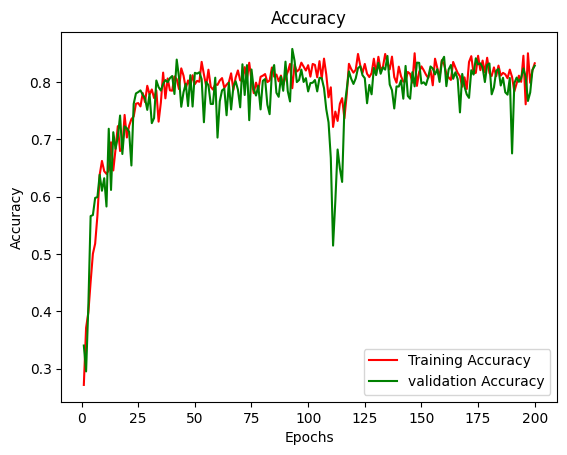

In [14]:
# Entraînement de l'autoencodeur
history = best_model.fit(
    x=train_dataset,  # Données d'entraînement
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,  # Données de validation
    validation_steps=VALIDATION_STEPS
)

# Affichage de la courbe de loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Affichage de la courbe de l'accuracy
loss = history.history['loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
psnr = evaluate_model(best_model, validation_dataset, VALIDATION_STEPS)
print(f'Average PSNR: {psnr:.2f} dB')

Batch 1: Calculated PSNR for 16 images.
Time for batch 1: 0.27 seconds
Batch 2: Calculated PSNR for 13 images.
Time for batch 2: 0.28 seconds
Evaluated 2 batches in total.
Total evaluation time: 1.06 seconds
Average PSNR: 26.42 dB
Average PSNR: 26.42 dB


### Meilleur modèle pour une utilisation future

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model

def create_best_model():
    # Encoder
    encoder_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = Conv2D(64, 3, activation='relu', padding='same')(encoder_input)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(160, 3, activation='relu', padding='same')(x)
    encoder = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(128, 3, activation='relu', padding='same')(encoder)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(160, 3, activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoder_output = Conv2D(3, 3, activation='sigmoid', padding='same')(x)

    # Create the model
    model = Model(encoder_input, decoder_output)

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001772507252479043)
    model.compile(optimizer=optimizer, loss='mse', metrics=["accuracy"])

    return model

# Create the model
denoiser = create_best_model()

denoiser.summary()

# Train the model
denoiser.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=validation_dataset, validation_steps=VALIDATION_STEPS)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 160)     92320     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 160)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       184448

2024-04-25 08:42:25.473859: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-04-25 08:42:37.310104: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdab14b58d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-25 08:42:37.310142: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-04-25 08:42:37.314496: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714034557.379680    7066 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-04-25 08:42:39.243828: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.67GiB with freed_by_count=0. The caller

7/7 [==============================] - 36s 3s/step - loss: 0.0810 - accuracy: 0.3594 - val_loss: 0.0531 - val_accuracy: 0.5317
Epoch 2/200
7/7 [==============================] - 2s 361ms/step - loss: 0.0519 - accuracy: 0.4101 - val_loss: 0.0311 - val_accuracy: 0.4009
Epoch 3/200
7/7 [==============================] - 2s 332ms/step - loss: 0.0258 - accuracy: 0.4661 - val_loss: 0.0245 - val_accuracy: 0.4846
Epoch 4/200
7/7 [==============================] - 2s 330ms/step - loss: 0.0201 - accuracy: 0.4761 - val_loss: 0.0186 - val_accuracy: 0.5322
Epoch 5/200
7/7 [==============================] - 2s 371ms/step - loss: 0.0170 - accuracy: 0.5074 - val_loss: 0.0138 - val_accuracy: 0.4943
Epoch 6/200
7/7 [==============================] - 3s 400ms/step - loss: 0.0137 - accuracy: 0.5569 - val_loss: 0.0123 - val_accuracy: 0.5758
Epoch 7/200
7/7 [==============================] - 3s 410ms/step - loss: 0.0112 - accuracy: 0.6243 - val_loss: 0.0116 - val_accuracy: 0.6050
Epoch 8/200
7/7 [==========

Le `best_model` est légèrement meilleur que le modèle de base en termes d'accuracy. De plus il généralise mieux. Cependant, le modèle oscille toujours aux alentours de 0.8 ce qui signifie qu'il faudrait avoir une plus grande quantité de données pour améliorer les performances.

La valeur du `PSNR (26 dB)` pour best__model est beaucoup plus proche de la valeur 30dB qui est généralement considérée comme acceptable pour du denoising.

## 5. Sauvegarde de l'autoencodeur

Sauvegardons notre modèle pour pouvoir l'utiliser ultérieurement.

In [ ]:
denoiser.save('denoiser.keras') # Sauvegarde du meilleur modèle

In [15]:
autoencoder.save('livrable_2_autoencoder.keras')  # Sauvegarde du modèle

## Conclusion 
 
Dans notre livrable, nous avons mis en œuvre un auto-encodeur pour le débruitage d'images. À partir d'un ensemble initial de 150 images, nous avons constitué des jeux de données en respectant une répartition de 80% pour l'entraînement et 20% pour la validation. Afin d'enrichir notre base de données, nous avons généré des duplicatas de nos images en y apportant diverses modifications. Plusieurs types de bruits ont été introduits dans nos images pour garantir une variété suffisante. Par la suite, nous avons appliqué un auto-encodeur doté de couches convolutives pour traiter ces images. Pour évaluer la performance de notre débruitage, nous avons utilisé la mesure PSNR (Peak Signal-to-Noise Ratio) en comparaison avec les images originales. Enfin, nous avons mis en œuvre un algorithme de tuning pour optimiser les performances de notre modèle.